In [ ]:
from google.colab import drive
drive.mount(f'/content/drive')
%cd 'drive/MyDrive/BDP_Final_Project'

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

Mounted at /content/drive
/content/drive/MyDrive/BDP_Final_Project
--2023-02-13 17:29:04--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M  52.9MB/s    in 5.4s    

2023-02-13 17:29:09 (52.8 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/R

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, StringType, BooleanType, FloatType
from pyspark.sql.functions import udf, col, month, hour
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import count, desc, when, col, lit, sum
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import os, findspark
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import desc, col, count
from pyspark.sql.window import Window
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_date, to_utc_timestamp, to_timestamp
from sklearn.cluster import KMeans
from scipy.stats import norm

warnings.filterwarnings('ignore')

In [ ]:
spark = SparkSession.builder.appName('treatmeant').getOrCreate()

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
findspark.init()

In [ ]:
def remove_old_data(df, start_year='2022'):
  """
    a pre processing function which is used to remove data which is before 2022
  """
  start_date = lit(start_year + "-01-01").cast(TimestampType())
  return df.filter(col('Date') >= start_date)

def remove_redundant_columns(df):
  """
    a pre processing function which deletes not needed columns (such that do not
    help us - like ID, Names etc...)
  """
  needed_columns = ['Date', 'Block', 'Primary Type', 'Location Description', 
                    'Arrest', 'Location', 'Community Area', 'District', 'Ward',
                    'Latitude', 'Longitude']
  
  df = df.select([col for col in df.columns if col in needed_columns])
  return df.dropna(how='any')

from pyspark.ml.clustering import KMeans
def add_columns_to_group_from(df, k=20):
  """
    this function is used to divide the geographical locations (lat, long) to K
    different groups -> to check areas with more/less or specific crimes
  """
  kmeans = KMeans(k=k)
  assembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
  df = assembler.transform(df)

  model = kmeans.fit(df)
  df = model.transform(df)
  df = df.withColumnRenamed("prediction", "Geo Type")
  
  df = df.withColumn("Month", month(col("Date")))
  df = df.withColumn("Hour", hour(col("Date")))
  
  def daily_type_setter(hour):
    """
      this function is used to split the day for morning, evening and night
    """
    if 4 <= hour < 12:
      return 'Morning'
    elif 12 <= hour < 20:
      return 'Evening'
    else:
      return 'Night'
      
  daily_type_setter_udf = udf(daily_type_setter, StringType())
  df = df.withColumn("Hour Type", daily_type_setter_udf(col("Hour")))
  
  return df


def plot_top_10_primary_type_probabilities(df, time_column):
    """
      this function is used to plot a heatmap of the probabilities of crimes,
      in a given manner
    """
    # Get the top 10 values in Primary Type that occurred the most
    top_10_primary_types = df.groupBy("Primary Type").count().sort("count", ascending=False).limit(10).select("Primary Type").rdd.flatMap(lambda x: x).collect()

    # Filter the data to only include the top 10 values in Primary Type
    df = df.filter(df["Primary Type"].isin(top_10_primary_types))

    # Calculate the probabilities of each value in Primary Type for each month
    primary_type_counts = df.groupBy(["Primary Type", time_column]).count().sort("count", ascending=False)

    # Plot the probabilities of each value in Primary Type for each month
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(primary_type_counts.toPandas().pivot(index=time_column, columns='Primary Type', values='count').apply(lambda x: x/x.sum(), axis=1), cmap="YlGnBu", annot=True, fmt='.2f', ax=ax)
    ax.set_title('Probabilities of each value in Primary Type (Top 10) for each month')
    ax.set_xlabel('Crimes')
    ax.set_ylabel(time_column)
    plt.show()

def plot_top_10_primary_type_occurrences_by_column(df, column):
    """
      this function is used to plot the occurrences of all the crimes given a specific
      manner
    """
    # Count the occurrences of each value in the Primary Type column
    primary_type_counts = df.groupBy("Primary Type").agg(count("*").alias("count"))\
                           .sort(desc("count"))

    # Keep only the top 10 values
    top_10_primary_types = primary_type_counts.limit(10).rdd.map(lambda row: row["Primary Type"]).collect()
    
    # Filter the dataframe to include only the top 10 values in the Primary Type column
    df_top_10 = df.filter(col("Primary Type").isin(top_10_primary_types))

    # Create a pivot table to count the occurrences of each value in the Primary Type column for each value in the checked column
    pivot_table = df_top_10.groupBy(column, "Primary Type").agg(count("*").alias("count"))\
                        .groupBy(column).pivot("Primary Type").agg(sum("count"))

    # Plot the pivot table as bar plots using seaborn
    plt.figure(figsize=(10,5))
    sns.barplot(data=pivot_table.toPandas())
    plt.title(f'Occurrences of the top 10 values in Primary Type for each value in {column}')
    plt.xlabel('Crimes')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

import pandas as pd
def plot_top_10_variances(df, columns):
    """
      this function is used to plot the variances of each crime given a manner
    """
    primary_type_counts = df.groupBy("Primary Type").agg(F.count("*").alias("count"))
    top_10_primary_types = primary_type_counts.sort(F.desc("count")).limit(10).rdd.map(lambda row: row["Primary Type"]).collect()
    df_top_10 = df.filter(df['Primary Type'].isin(top_10_primary_types))
    variances_df = pd.DataFrame(columns=columns)
    for column in columns:
        pivot_table = df_top_10.groupBy(column, "Primary Type").agg(F.count("*").alias("count"))
        pivot_table = pivot_table.groupBy(column).pivot("Primary Type").agg(F.mean("count"))

        for col in top_10_primary_types:
            min_val = pivot_table.agg(F.min(col)).collect()[0][0]
            max_val = pivot_table.agg(F.max(col)).collect()[0][0]
            pivot_table = pivot_table.withColumn(col, (pivot_table[col] - min_val) / (max_val - min_val))
        
        variances = list(pivot_table.toPandas().var(axis=0))
        if len(variances) != len(top_10_primary_types):
            variances = variances[1:]

        variances_df[column] = variances

    variances_df.index = top_10_primary_types
    return variances_df


#Loading The Data

In [ ]:

schema = StructType([
    StructField("Unnamed: 0", StringType()),
    StructField("ID", StringType()),
    StructField("Case Number", StringType()),
    StructField("Date", StringType()),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", BooleanType(), True),
    StructField("Domestic", BooleanType(), True),
    StructField("Beat", FloatType(), True),
    StructField("District", FloatType(), True),
    StructField("Ward", FloatType(), True),
    StructField("Community Area", FloatType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", FloatType()),
    StructField("Longitude", FloatType()),
    StructField("Location", StringType())])

df = spark.read.csv('chicago_crimes.csv', schema=schema, header=True)
df.show(5)

+----------+--------+-----------+-------------------+--------------------+----+--------------------+----------------+--------------------+------+--------+------+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|Unnamed: 0|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|     Description|Location Description|Arrest|Domestic|  Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|
+----------+--------+-----------+-------------------+--------------------+----+--------------------+----------------+--------------------+------+--------+------+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|      2018|12787319|   JF348814|2022-08-02 07:00:00|134XX S BALTIMORE...|0810|               THEFT|       OVER $500| 

#Pre Processing

In [ ]:
df = remove_old_data(df)
df = remove_redundant_columns(df)
df = add_columns_to_group_from(df)

df.show(5)

+-------------------+--------------------+--------------------+--------------------+------+--------+----+--------------+---------+----------+--------------------+--------------------+--------+-----+----+---------+
|               Date|               Block|        Primary Type|Location Description|Arrest|District|Ward|Community Area| Latitude| Longitude|            Location|            features|Geo Type|Month|Hour|Hour Type|
+-------------------+--------------------+--------------------+--------------------+------+--------+----+--------------+---------+----------+--------------------+--------------------+--------+-----+----+---------+
|2022-08-02 07:00:00|134XX S BALTIMORE...|               THEFT|              STREET| false|     4.0|10.0|          55.0|41.651398| -87.54716|(41.651396287, -8...|[41.6513977050781...|      10|    8|   7|  Morning|
|2022-08-06 03:10:00|  001XX N WALLER AVE| MOTOR VEHICLE THEFT|              STREET| false|    15.0|29.0|          25.0| 41.88326| -87.76823|(41

#Feature Importance - Decision Tree

In [ ]:
def get_features_importance(df, categorical_columns=["Hour Type"], numeric_columns=["Hour", "Month", "Geo Type"], target_col='Primary Type'):
  """
    this function is used to check the importance of each feature we check, 
    while trying to predict crimes.
  """
  
  categorical_columns = categorical_columns
  numeric_columns = numeric_columns
  indexers = [
      StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep')
      for c in categorical_columns]

  encoders = [OneHotEncoder(dropLast=False,inputCol=f"{c}_indexed", outputCol=f"{c}_encoded")
              for c in categorical_columns]

  assembler = VectorAssembler(inputCols = numeric_columns + [f"{c}_encoded" for c in categorical_columns], outputCol="features", handleInvalid='keep')
  class_indexer = StringIndexer(inputCol=target_col, outputCol='CLASS_indexed', handleInvalid='skip')
  dt = DecisionTreeClassifier(labelCol="CLASS_indexed", featuresCol="features")

  (trainingData, testData) = df.randomSplit([0.7, 0.3])

  # Train the decision tree model
  new_data = indexers[0].fit(df).transform(df)

  for indexer in indexers[1:]:
      new_data = indexer.fit(new_data).transform(new_data)

  for encoder in encoders:
      new_data = encoder.fit(new_data).transform(new_data)

  new_data = new_data.drop('features')

  new_data = assembler.transform(new_data)
  new_data = class_indexer.fit(new_data).transform(new_data).select('features', 'CLASS_indexed')

  model = dt.fit(new_data)
  importances = model.featureImportances
  feature_importances = {assembler.getInputCols()[i]: importances[i] for i in range(len(assembler.getInputCols()))}
  for feature, imp in feature_importances.items():
    print(f"The importance of {feature}: {imp} ")

get_features_importance(df)

The importance of Hour: 0.0495428684174565 
The importance of Month: 0.10886948023893503 
The importance of Geo Type: 0.7812903378277309 
The importance of Hour Type_encoded: 0.0 


#Analysis and Visualization

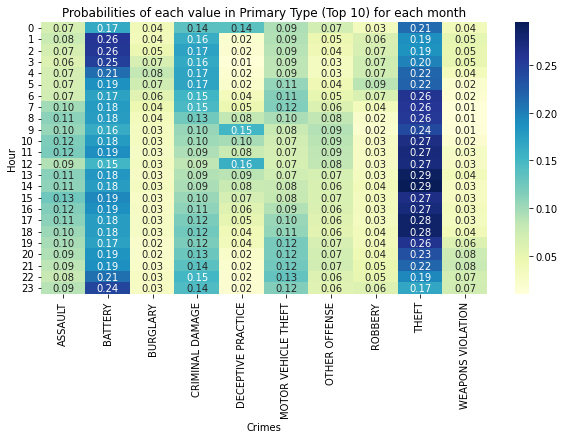

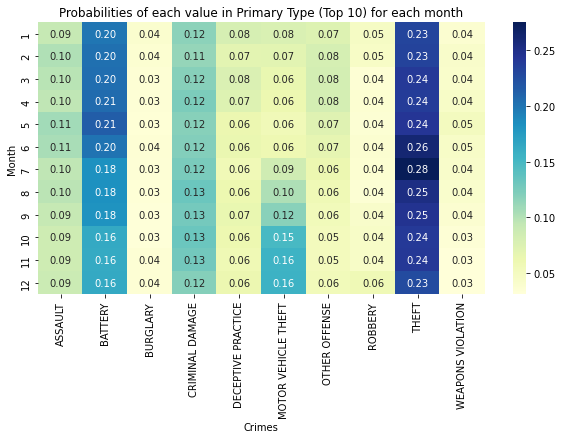

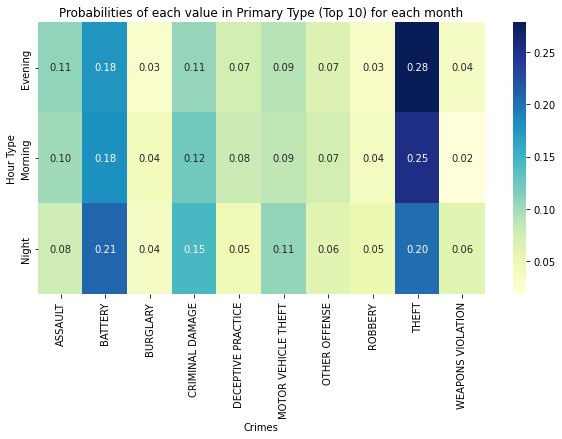

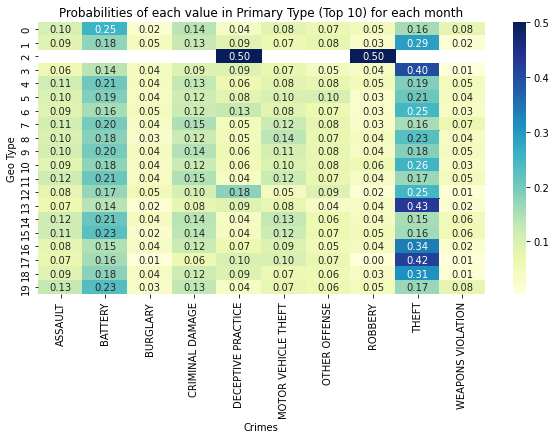

In [ ]:
for column in ['Hour', 'Month', 'Hour Type', 'Geo Type']:
  plot_top_10_primary_type_probabilities(df, time_column=column)

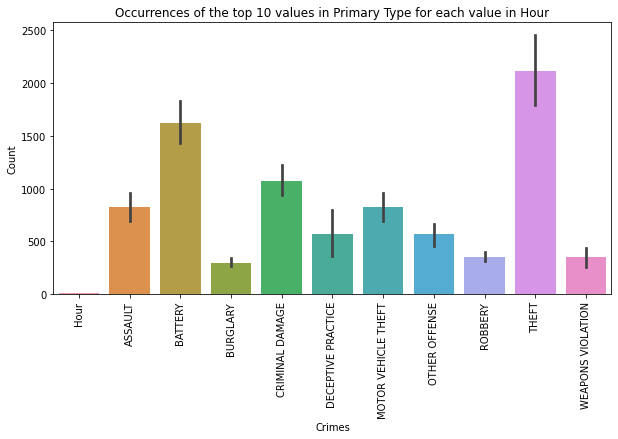

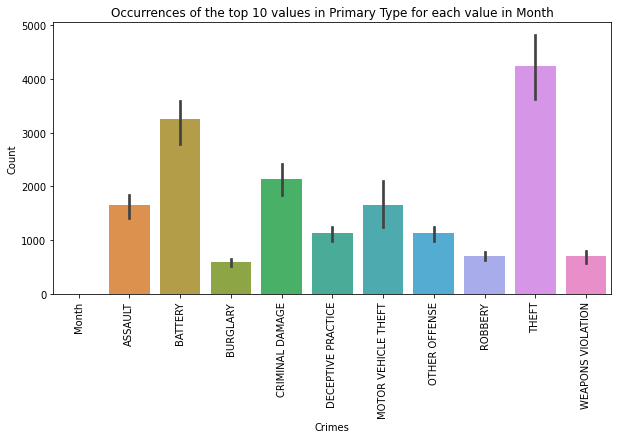

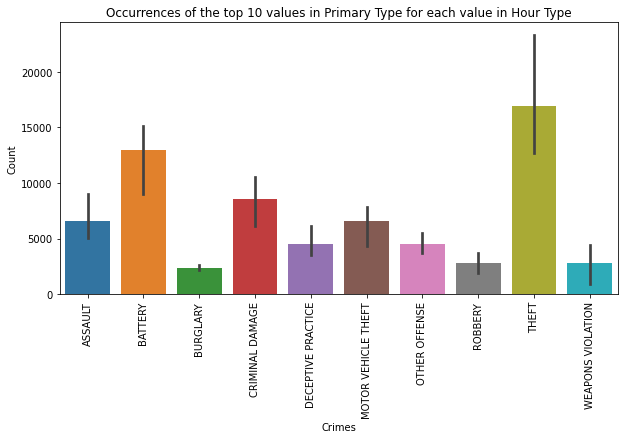

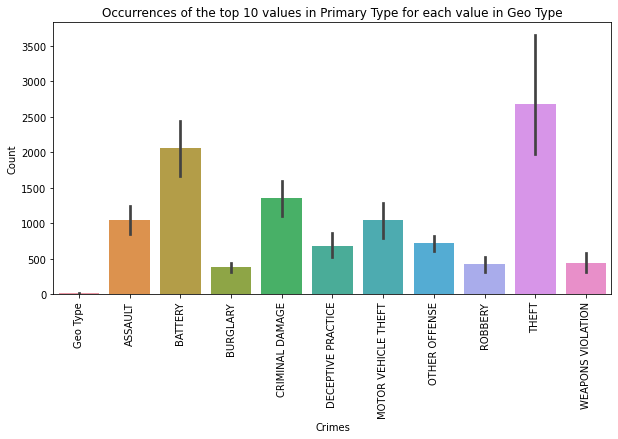

In [ ]:
for column in ['Hour', 'Month', 'Hour Type', 'Geo Type']:
  plot_top_10_primary_type_occurrences_by_column(df, column)

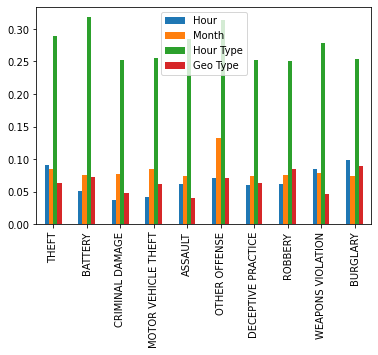

In [ ]:
variances_df = plot_top_10_variances(df, ['Hour', 'Month', 'Hour Type', 'Geo Type'])
variances_df.plot.bar()
